# **Advanced Machine Learning Methods**
## **Maestría en Inteligencia Artificial Aplicada**
### **Dr. José Antonio Cantoral Ceballos**
### **Tecnológico de Monterrey**
## **Activity 2b: Building a CNN for CIFAR10 Dataset with PyTorch**
---

### Team 7

- Rodrigo Robledo Castillo - A01797582
- Pedro David Juarez Leyva - A01797041
- Emilio Contreras Téllez - A01111353
- Omar Aguilar Macedo - A0179707

# Table of Contents

1. [Activity 2b: Building a CNN for CIFAR10 Dataset with PyTorch](#activity2c)
2. [Introduction](#intro)
3. [Download CIFAR-10](#download-cifar-10)
4. [Select GPU/CPU device](#pick-gpu-cpu)
5. [Display Images](#display-images)
6. [Accuracy](#accuracy)
7. [Training Loop](#training-loop)
8. [Linear Model (baseline)](#linear-model)
9. [Sequential CNN](#sequential-cnn)
10. [Architecture Description](#arch-description)
11. [Conclusion](#conclusion)

# TC 5033
## Deep Learning
## Convolutional Neural Networks
<br>

#### Activity 2b: Building a CNN for CIFAR10 dataset with PyTorch <a name="activity2c" />
<br>

- Objective

    The main goal of this activity is to further your understanding of Convolutional Neural Networks (CNNs) by building one using PyTorch. You will apply this architecture to the famous CIFAR10 dataset, taking what you've learned from the guide code that replicated the Fully Connected model in PyTorch (Activity 2a).

- Instructions
    This activity requires submission in teams of 5 or 6 members. Submissions from smaller or larger teams will not be accepted unless prior approval has been granted (only due to exceptional circumstances). While teamwork is encouraged, each member is expected to contribute individually to the assignment. The final submission should feature the best arguments and solutions from each team member. Only one person per team needs to submit the completed work, but it is imperative that the names of all team members are listed in a Markdown cell at the very beginning of the notebook (either the first or second cell). Failure to include all team member names will result in the grade being awarded solely to the individual who submitted the assignment, with zero points given to other team members (no exceptions will be made to this rule).

    Understand the Guide Code: Review the guide code from Activity 2a that implemented a Fully Connected model in PyTorch. Note how PyTorch makes it easier to implement neural networks.

    Familiarize Yourself with CNNs: Take some time to understand their architecture and the rationale behind using convolutional layers.

    Prepare the Dataset: Use PyTorch's DataLoader to manage the dataset. Make sure the data is appropriately preprocessed for a CNN.

    Design the CNN Architecture: Create a new architecture that incorporates convolutional layers. Use PyTorch modules like nn.Conv2d, nn.MaxPool2d, and others to build your network.

    Training Loop and Backpropagation: Implement the training loop, leveraging PyTorch’s autograd for backpropagation. Keep track of relevant performance metrics.

    Analyze and Document: Use Markdown cells to explain your architectural decisions, performance results, and any challenges you faced. Compare this model with your previous Fully Connected model in terms of performance and efficiency.

- Evaluation Criteria

    - Understanding of CNN architecture and its application to the CIFAR10 dataset
    - Code Readability and Comments
    - Appropriateness and efficiency of the chosen CNN architecture
    - Correct implementation of Traning Loop and Accuracy Function
    - Model's performance metrics on the CIFAR10 dataset (at least 65% accuracy)
    - Quality of Markdown documentation

- Submission

Submit via Canvas your Jupyter Notebook with the CNN implemented in PyTorch. Your submission should include well-commented code and Markdown cells that provide a comprehensive view of your design decisions, performance metrics, and learnings.

# Introduction <a name="intro" />

In this assignment, Convolutional Neural Networks (CNNs) were explored for the classification task on the CIFAR-10 dataset, which consists of 32x32 RGB images distributed across 10 classes.



As a baseline, a fully connected neural network (MLP) was first implemented, treating each image as a flattened vector without exploiting its spatial structure. Subsequently, several convolutional architectures were designed in order to analyze the impact of:
- The incorporation of convolutional layers
- The use of Batch Normalization
- Different learning rates
- Regularization through weight decay

The main objective was to evaluate how these architectural and optimization choices influence the model's performance in terms of test accuracy.


## Dataset
- The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. (https://www.cs.toronto.edu/~kriz/cifar.html)


In [1]:
# @title Import Libraries

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
import matplotlib.pyplot as plt


### Download Cifar10 dataset <a name="download-cifar-10" />

In [2]:
# validate if GPU is available (through CUDA)
torch.cuda.is_available()

True

In [3]:
DATA_PATH = './cifar-10'
NUM_TRAIN = 50000
NUM_VAL = 5000
NUM_TEST = 5000
MINIBATCH_SIZE = 64

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Train dataset (50K)
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_cifar)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation and test sets were obtained from test set
# Validation set (5K images)
cifar10_val = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                           transform=transform_cifar)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))
# Test set (5K Images)
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_cifar)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL, len(cifar10_test))))

100%|██████████| 170M/170M [00:05<00:00, 28.9MB/s]


In [4]:
# Check contents of train dataset
cifar10_train

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [5]:
# Check contents of train dataset through train loader
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.491, 0.482, 0.447], std=[0.247, 0.243, 0.261])
           )

In [6]:
# Check shape of labels and features from test loader
for i, (x, y) in enumerate(test_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 32, 32]) torch.Size([64])
1 torch.Size([64, 3, 32, 32]) torch.Size([64])
2 torch.Size([64, 3, 32, 32]) torch.Size([64])
3 torch.Size([64, 3, 32, 32]) torch.Size([64])
4 torch.Size([64, 3, 32, 32]) torch.Size([64])
5 torch.Size([64, 3, 32, 32]) torch.Size([64])
6 torch.Size([64, 3, 32, 32]) torch.Size([64])
7 torch.Size([64, 3, 32, 32]) torch.Size([64])
8 torch.Size([64, 3, 32, 32]) torch.Size([64])
9 torch.Size([64, 3, 32, 32]) torch.Size([64])
10 torch.Size([64, 3, 32, 32]) torch.Size([64])
11 torch.Size([64, 3, 32, 32]) torch.Size([64])
12 torch.Size([64, 3, 32, 32]) torch.Size([64])
13 torch.Size([64, 3, 32, 32]) torch.Size([64])
14 torch.Size([64, 3, 32, 32]) torch.Size([64])
15 torch.Size([64, 3, 32, 32]) torch.Size([64])
16 torch.Size([64, 3, 32, 32]) torch.Size([64])
17 torch.Size([64, 3, 32, 32]) torch.Size([64])
18 torch.Size([64, 3, 32, 32]) torch.Size([64])
19 torch.Size([64, 3, 32, 32]) torch.Size([64])
20 torch.Size([64, 3, 32, 32]) torch.Size([64])
21

### Using GPUs (if available) <a name="pick-gpu-cpu" />

In [7]:
# If GPU is avaialble, use it, otherwise fallback to GPU
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


### Display images <a name="display-images" />

La imagen muestreada representa un: frog


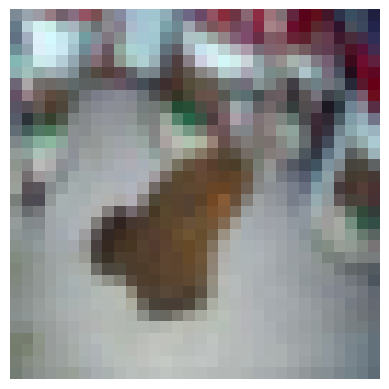

In [8]:
# Helper function to plot a figure from the dataset

# Class names
classes = test_loader.dataset.classes
def plot_figure(image):
    plt.imshow(np.transpose(image,(1,2,0)))
    plt.axis('off')
    plt.show()

# Pick a random image and display it along with its label
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)


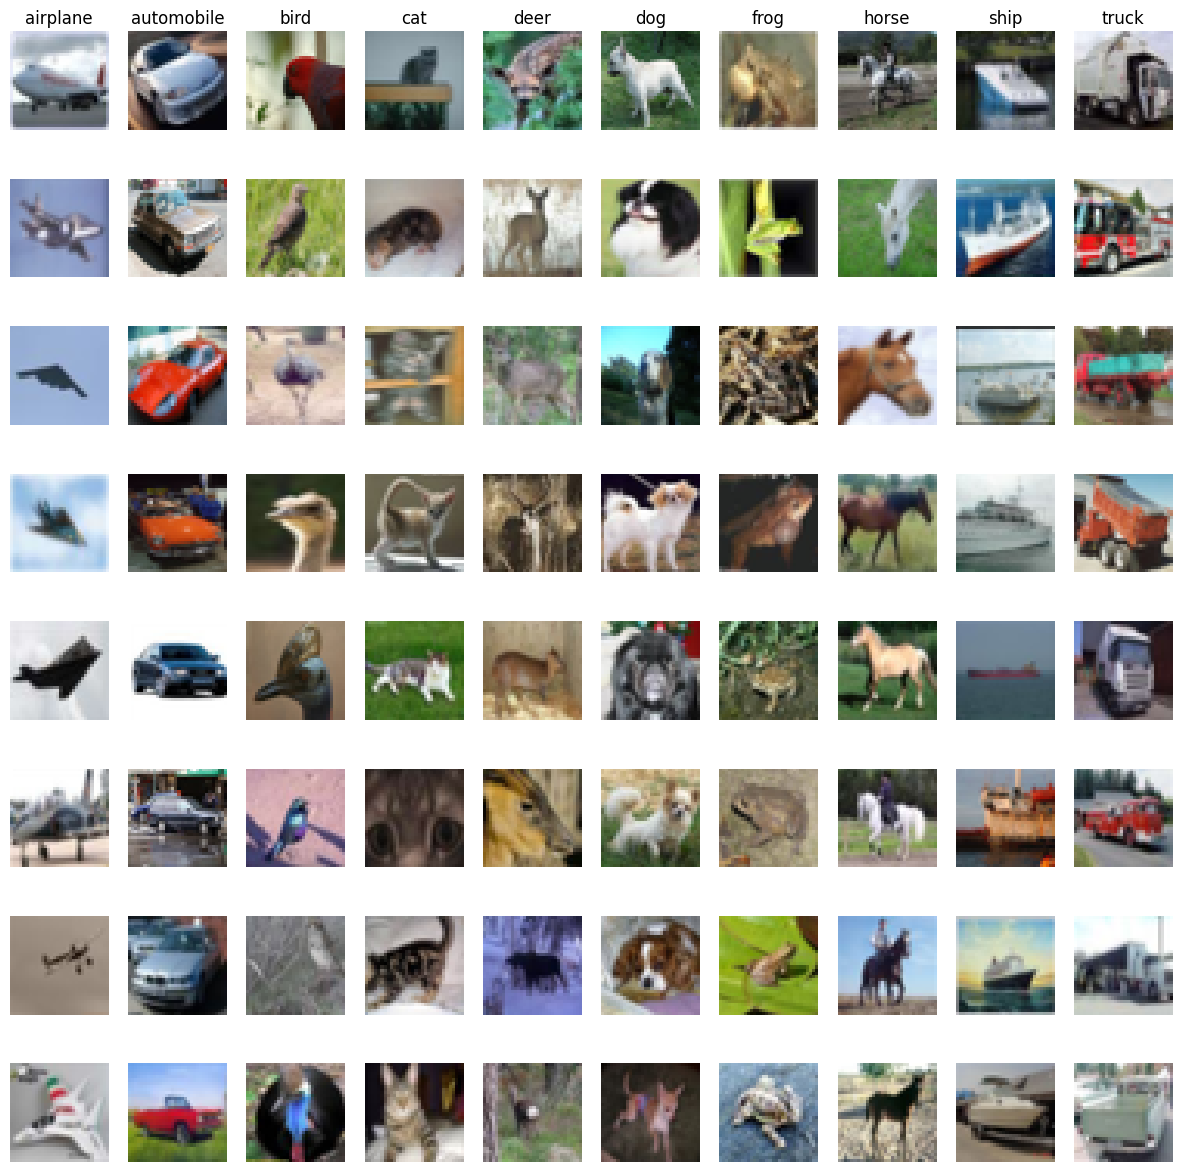

In [9]:
# Util funtion to plot 8 rabndom samples of each class
def plot_cifar10_grid():
    classes = test_loader.dataset.classes
    total_samples = 8
    plt.figure(figsize=(15,15))
    for label, sample in enumerate(classes):
        class_idxs = np.flatnonzero(label == np.array(test_loader.dataset.targets))
        sample_idxs = np.random.choice(class_idxs, total_samples, replace = False)
        for i, idx in enumerate(sample_idxs):
            plt_idx = i*len(classes) + label + 1
            plt.subplot(total_samples, len(classes), plt_idx)
            plt.imshow(test_loader.dataset.data[idx])
            plt.axis('off')

            if i == 0: plt.title(sample)
    plt.show()

plot_cifar10_grid()

### Accuracy <a name="accuracy" />


In [10]:
def accuracy(model, loader):
  num_correct = 0 # Counter for correctly predicted samples
  num_total = 0   # Counter for total evaluated samples

  model.eval()    # Switch model to evaluation mode (affects BatchNorm/Dropout)
  model = model.to(device=device) # Ensure model is on the correct device (CPU/GPU)

  # Disable gradient computation to reduce memory usage and speed up inference
  with torch.no_grad():
    for xi, yi in loader:
      # Move inputs and labels to device
      xi = xi.to(device=device, dtype=torch.float32)
      yi = yi.to(device=device, dtype=torch.long)

      # Fowrard pass
      scores = model(xi)

      # Get predicted class (index of maximum logit)
      pred = scores.argmax(dim=1)

      # Count correct predictions
      num_correct += (pred == yi).sum().item()
      num_total += yi.size(0)

  # Return classification accuracy
  return num_correct / num_total


### Training Loop <a name="training-loop" />

In [11]:
def train(model, optimizer, epochs=100):
    # Move model to selected device (CPU or GPU)
    model = model.to(device=device)

    for epoch in range(epochs):
      model.train() # Set model to training mode

      for i, (xi, yi) in enumerate(train_loader):
        # Move batch to device
        xi = xi.to(device=device, dtype=torch.float32)
        yi = yi.to(device=device, dtype=torch.long)

        # Forward pass: compute predictions (logits)
        scores = model(xi)

        # Compute cross-entropy loss between predictions and ground truth
        loss = F.cross_entropy(scores, yi)

        # Reset gradients from previous iteration
        optimizer.zero_grad()

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters
        optimizer.step()

      # Evaluate model on validation set after each epoch
      acc = accuracy(model, val_loader)
      print(f'Epoch: {epoch + 1}, cost: {loss.item()}, accuracy: {acc}')

### Linear Model <a name="linear-model" />

In [12]:
# To do: Use PyTorch to create a linear model to have an initial baseline model

# Total number of input features (3 channels (RGB) x 32 x 32 pixels)
input_features = 3 * 32 * 32

# Number of neurons in hidden layers
hidden_01 = 256
hidden_02 = 256

# Number of output classes
output_features = 10

# Parameters
lr = 1e-3;
epochs = 10

# Baseline MLP model that flattens the image and applies fully connected layers
model1 = nn.Sequential(
    nn.Flatten(), # Convert image tensor (3x32x32) into a 1D vector
    nn.Linear(input_features, hidden_01), nn.ReLU(), # First hidden layer activation
    nn.Linear(hidden_01, hidden_02), nn.ReLU(),      # Second hidden layer activation
    nn.Linear(hidden_02, output_features) # Output logits (no softmax used)
)

# Simple Adam optimizer
optimizer = torch.optim.Adam(model1.parameters(), lr=lr)

In [13]:
train(model1, optimizer, epochs)

Epoch: 1, cost: 1.7005329132080078, accuracy: 0.4572
Epoch: 2, cost: 1.407041072845459, accuracy: 0.4988
Epoch: 3, cost: 1.1602065563201904, accuracy: 0.5132
Epoch: 4, cost: 0.9410719871520996, accuracy: 0.51
Epoch: 5, cost: 1.423476219177246, accuracy: 0.5236
Epoch: 6, cost: 0.6329309940338135, accuracy: 0.5252
Epoch: 7, cost: 0.5722183585166931, accuracy: 0.5298
Epoch: 8, cost: 0.8502507209777832, accuracy: 0.5342
Epoch: 9, cost: 1.0370447635650635, accuracy: 0.517
Epoch: 10, cost: 1.7799766063690186, accuracy: 0.5304


In [14]:
accuracy(model1, test_loader)

0.52

### Sequential CNN <a name="sequential-cnn" />

In [15]:
# @title CNN `lr = 1e-4` and Batch Normalization

# To do: Use PyTorch to implement a CNN model, accuracy should be better than
# the linear model

# Input channels (RGB images)
initial_channels = 3

# Number of filters per convolutional block
channel_01 = 16
channel_02 = 32
channel_03 = 64

# Number of output classes
out_features = 10

# Parameters
epochs = 10
lr = 1e-4

# Convolutional Neural Network architecture
modelCNN1 = nn.Sequential(
    # Block 1
    # Extract low-level features
    nn.Conv2d(initial_channels, channel_01, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_01), # Normalize activations for training stability
    nn.ReLU(inplace = True),

    # Block 2
    # Increase feature complexity
    nn.Conv2d(channel_01, channel_02, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_02),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2),  # Downsample spatial resolution (32 -> 16)

    # Block 3
    # Further increase representation capacity
    nn.Conv2d(channel_02, channel_03, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_03),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2), #  Downsample spatial resolution (16 -> 8)

    # Classification
    nn.Flatten(), # Convert feature maps into a vector
    nn.Linear(channel_03 * 8 * 8, out_features) # Output logits for 10 classes
)

# Adam optimizer
optimizer = torch.optim.Adam(modelCNN1.parameters(), lr=lr)

In [16]:
train(modelCNN1, optimizer, epochs)

Epoch: 1, cost: 1.1388649940490723, accuracy: 0.5634
Epoch: 2, cost: 1.2664268016815186, accuracy: 0.6206
Epoch: 3, cost: 0.8736082911491394, accuracy: 0.655
Epoch: 4, cost: 1.0964109897613525, accuracy: 0.6584
Epoch: 5, cost: 0.6729535460472107, accuracy: 0.6876
Epoch: 6, cost: 1.310431718826294, accuracy: 0.6814
Epoch: 7, cost: 0.42813441157341003, accuracy: 0.7024
Epoch: 8, cost: 0.4447501599788666, accuracy: 0.7014
Epoch: 9, cost: 0.4034688472747803, accuracy: 0.7088
Epoch: 10, cost: 0.9666251540184021, accuracy: 0.7066


In [17]:
accuracy(modelCNN1, test_loader)

0.7048

In [18]:
# @title CNN `lr = 1e-3` and Batch Normalization

# Input channels (RGB images)
initial_channels = 3

# Number of filters per convolutional block
channel_01 = 16
channel_02 = 32
channel_03 = 64

# Number of output classes
out_features = 10

# Parameters
epochs = 10
lr = 1e-3


# Convolutional Neural Network architecture
modelCNN2 = nn.Sequential(
    # Block 1
    # Extract low-level features
    nn.Conv2d(initial_channels, channel_01, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_01), # Normalize activations for training stability
    nn.ReLU(inplace = True),

    # Block 2
    # Increase feature complexity
    nn.Conv2d(channel_01, channel_02, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_02),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2), # 32 > 16

    # Block 3
    # Further increase representation capacity
    nn.Conv2d(channel_02, channel_03, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_03),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2), # 16 > 8

    # Classification
    nn.Flatten(), # Convert feature maps into a vector
    nn.Linear(channel_03 * 8 * 8, out_features) # Output logits for 10 classes
)

# Adam optimizer
optimizer2 = torch.optim.Adam(modelCNN2.parameters(), lr=lr)

In [19]:
train(modelCNN2, optimizer2, epochs)

Epoch: 1, cost: 1.052366018295288, accuracy: 0.6376
Epoch: 2, cost: 0.5155313014984131, accuracy: 0.6968
Epoch: 3, cost: 1.0180933475494385, accuracy: 0.7266
Epoch: 4, cost: 0.5010861158370972, accuracy: 0.7262
Epoch: 5, cost: 0.9215184450149536, accuracy: 0.7168
Epoch: 6, cost: 0.9957275390625, accuracy: 0.7162
Epoch: 7, cost: 0.9524928331375122, accuracy: 0.7508
Epoch: 8, cost: 0.18623404204845428, accuracy: 0.7412
Epoch: 9, cost: 0.6282872557640076, accuracy: 0.742
Epoch: 10, cost: 0.21598052978515625, accuracy: 0.7534


In [20]:
accuracy(modelCNN2, test_loader)

0.7478

In [21]:
# @title CNN `lr = 1e-3`, Batch Normalization and `weight_decay=1e-4`

# Input channels (RGB images)
initial_channels = 3

# Number of filters per convolutional block
channel_01 = 16
channel_02 = 32
channel_03 = 64

# Number of output classes
out_features = 10

# Parameters
epochs = 10
lr = 1e-3
weight_decay = 1e-4 # L2 regularization factor

# Convolutional Neural Network architecture
modelCNN3 = nn.Sequential(
    # Block 1
    # Extract low-level features
    nn.Conv2d(initial_channels, channel_01, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_01),
    nn.ReLU(inplace = True),

    # Block 2
    # Increase feature complexity
    nn.Conv2d(channel_01, channel_02, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_02),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2), # 32 > 16

    # Block 3
    # Further increase representation capacity
    nn.Conv2d(channel_02, channel_03, kernel_size=3, padding=1, bias = False),
    nn.BatchNorm2d(channel_03),
    nn.ReLU(inplace = True),
    nn.MaxPool2d(kernel_size=2, stride=2), # 16 > 8

    # Classification
    nn.Flatten(), # Convert feature maps into a vector
    nn.Linear(channel_03 * 8 * 8, out_features) # Output logits for 10 classes
)

# Adam optimizer with weight decay for better generalization

optimizer3 = torch.optim.Adam(modelCNN3.parameters(), lr=lr, weight_decay=weight_decay)


In [22]:
train(modelCNN3, optimizer3, epochs)

Epoch: 1, cost: 0.6905636787414551, accuracy: 0.6478
Epoch: 2, cost: 0.5417826771736145, accuracy: 0.697
Epoch: 3, cost: 1.0941746234893799, accuracy: 0.7186
Epoch: 4, cost: 0.5922001600265503, accuracy: 0.7426
Epoch: 5, cost: 0.5454643368721008, accuracy: 0.7298
Epoch: 6, cost: 0.5144359469413757, accuracy: 0.7398
Epoch: 7, cost: 0.7343072891235352, accuracy: 0.742
Epoch: 8, cost: 0.7056587338447571, accuracy: 0.7216
Epoch: 9, cost: 0.40378957986831665, accuracy: 0.7494
Epoch: 10, cost: 0.7394142746925354, accuracy: 0.738


In [23]:
accuracy(modelCNN3, test_loader)

0.7466

# Architecture Description <a name="arch-description" />

The best-performing architecture corresponds to a CNN composed of three convolutional blocks with a progressive increase in the number of channels:

## General Structure

#### **Block 1**

* Conv2D ($3 \rightarrow 16$)
* BatchNorm2d
* ReLU

#### **Block 2**

* Conv2D ($16 \rightarrow 32$)
* BatchNorm2d
* ReLU
* MaxPool2d ($32x32 \rightarrow 16x16$)

#### **Block 3**

* Conv2D ($32 \rightarrow 64$)
* BatchNorm2d
* ReLU
* MaxPool2d ($16x16 \rightarrow 8x8$)

#### **Classifier**
* Flatten
* Linear ($64 x 8 x 8 \rightarrow 10$)

### Design Considerations

* $3x3$ kernels with `padding=1` were used to preserve spatial dimensions.
* The bias term was removed from convolutional layers (`bias=False`) since Batch Normalization introduces its own learnable shift parameter.
* Spatial resolution was progressively reduced through MaxPooling.

The channel progression ($16 \rightarrow 32 \rightarrow 64$) increases representational capacity as spatial resolution decreases, maintaining a balance between model complexity and computational cost.

# Conclusion <a name="conclusion" />

The results clearly demonstrate the importance of convolutional architectures for image classification tasks. The fully connected baseline achieved 52% accuracy, highlighting the limitations of ignoring the spatial structure of images.

Introducing convolutional layers resulted in a significant improvement (over 20 percentage points), confirming that hierarchical extraction of local features is fundamental in computer vision problems.

Using a higher learning rate ($10^{-3}$) accelerated training and improved accuracy compared to $10^{-4}$. Giving the best final performance (74.78%)

A run incorporating weight decay was made, this resulted in similar results when this parameter was not used, this suggests that penalizing large weights does not make a real impact at least for this dataset with the choosen parameters.

In conclusion, during this activity we saw that:
- Architectural design is more impactful than simply increasing parameter count.
- Batch Normalization improves training stability.
- Optimizer configuration and regularization directly influence generalization performance.

Even relatively simple CNN architectures can achieve competitive performance on CIFAR-10 when properly configured.